## Style transform mini project
### Also test PyTorch 2.0, the acceleration on M1 chip

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


First we need to read preprocess and post protest the content image and the style image

In [7]:
def read_image(file_path):
    # read the image
    try:
        img = Image.open(file_path)
        if img.mode == 'RGBA':
            img = img.convert("RGB")

        img_array = np.asarray(img)
        return img, img_array
    except IOError:
        print(f"Unable to read image: {file_path}")
        return None

so now we have
1. two images with three channels. but those images are too large to train
2. these two image has difference size

So we need to resize them

In [8]:
def pre_process(img, img_size):
    rgb_mean = torch.tensor([0.485, 0.456, 0.406])
    rgb_std = torch.tensor([0.229, 0.224, 0.225])
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean,
                                         std=rgb_std)])
    return transforms(img).unsqueeze(0)

def post_process(img):
    rgb_mean = torch.tensor([0.485, 0.456, 0.406])
    rgb_std = torch.tensor([0.229, 0.224, 0.225])
    img = img[0]
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [9]:
# tensor_test = pre_process(style_image, image_shape)
# image_test = post_process(tensor_test)
# image_test.show()

We employ the VGG 19 model, introduced in 2014, for this project. VGG 19 (or VGG 16) is a well-known CNN model with 3x3 convolutional layers and 2x2 pooling layers. We will not delve into the details of CNNs in this project, but it is essential to understand the following points:
1. Generally, layers closer to the input are more adept at extracting detailed image information. Hence, we select a layer closer to the VGG output as the content layer to generate the content features of the image.
2. We choose the outputs of various VGG layers to match local and global styles. These layers are referred to as style layers.
3. VGG is a model with a large number of parameters, with the majority found in the first Fully Connected Neural Network (FNN) layer. However, in this project, the fully connected layers are discarded.
4. This project does not involve training a model, so the model's parameters remain unchanged during the training process.
5. Despite not training the model, we still need to train something: the composite images. This process will be discussed further later on.

In [26]:
pretrained_net = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
# print(pretrained_net)
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])
# print(net)
# we can see that the net we used here do not contain the full connect layers

In [27]:
def extract_features(x, content_layers, style_layers):
    """
    input:
    x: the input tensor for nn, could be orignal, or fake images
    content_layers: a list, contain the number(s) of layers we will take from VGG.
    style_layer: a list, contain the number(s) of layers we will take from VGG.

    return:
    contents: a list contain the output of content layers.
    styles: a list contain the output of style layers.
    """
    contents = []
    styles = []
    for i in range(len(net)):
        x = net[i](x)
        if i in style_layers:
            styles.append(x)
        if i in content_layers:
            contents.append(x)
    return contents, styles

In [28]:
def get_contents(content_img, image_shape, device):
    """
    content_img: PIL image
    image_shape: list

    return: 
    content_x: tensor of the pre-processed image
    content_y: output of the content layer
    """
    content_x = pre_process(content_img, image_shape).to(device)
    print(content_x.device)
    contents_y, _ = extract_features(content_x, content_layers, style_layers)
    return content_x, contents_y

def get_styles(style_img, image_shape, device):
    style_x = pre_process(style_img, image_shape).to(device)
    _, styles_y = extract_features(style_x, content_layers, style_layers)
    return style_x, styles_y

### loss function
1. Content loss: Content loss quantifies the discrepancy between the synthesized image and the content image in terms of content features, utilizing the squared error function to measure this difference.
2. Style loss: Style loss employs the Mean Squared Error (MSE) to calculate its value. However, a matrix called the "Gram matrix" is used to represent the style of the output from the style layer. The Gram matrix may not be well-understood, but it can be thought of as a method to "calculate" the "style."
3. Total variation loss: This concept might be unfamiliar, but it is often used to address the presence of high-frequency noise in composite images, which can manifest as grainy pixels that are exceptionally bright or dark. Total variation denoising is a common technique for reducing such noise.

The following code block demonstrates the implementation of these three loss types:

In [29]:
# this should be the core part of math, but I will ignore them since we are not study the graphics
# just know that we need to minimize both three loss is enough
# I will explain all three loss function
def content_loss(Y_hat, Y):
    """
    input:
    yhat: content of the synthesized image, output of content layer
    y: content of the original image, output of content layer
    yhat and y has the same size.
    return:
    mse loss
    """
    return torch.square(Y_hat - Y.detach()).mean()

def gram(X):
    """
    X: output of the style layer

    return:
    gram matrix
    """
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

The loss function for style transform is a weighted sum of content loss, style loss, and total change loss. By adjusting these weight hyperparameters, we can weigh the relative importance of the synthetic image in terms of preserving content, migrating style, and denoising.

In [42]:
@torch.compile
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y,
                 styles_Y_gram, content_weight, style_weight, tv_weight):
    """
    X:
    contents_Y_hat: list, the output form content layer(s), input is the fake content image
    contents_Y, list, the output form content layer(s), input is the orignal 

    style_Y_hat: list, the output form style layer(s), input is the fake image
    style_Y_gram: list, the output form style layer(s), calculate gram, input is the orignial image
    """
    # same len with content_layers, should be 1
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    # same len with style_layers, should be 5
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    # tensor
    tv_l = tv_loss(X) * tv_weight

    # sum over all loss value
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [31]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        # now we know that useing nn.Parameter is for auto-update and caluclate
        # gradient, however, how to use the SynthesizedImage?
        # we treat it as the target image or the "noise" added on the original image?
        # the answer is that we just treat it as the target image, 
        # the torch.rand is for nothing, can be changed to ones or zeros
        # the weight will be changed when we instantiate it, will see later
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [32]:
def get_inits(X, lr, styles_Y, device):
    """
    X: content x, note it is content x, not x content
    lr: learning rate
    styles_Y: the target style list, since we only need calculate it once, so do it here
    """
    # initialize a random image
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    # optimizer, use adam here, why?
    # just use adam for every job. even through this is stupid.. we ain't doing research anyway
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## Test

In [33]:
# pre-process image
content_image_path = 'ng.jpeg'
content_image, content_array = read_image(content_image_path)
content_image.show()

In [34]:
style_image_path = 'woman_with_a_hat.jpg'
style_image, style_array = read_image(style_image_path)
style_image.show()

We observe that the most time-consuming components are the `extract_features()` and `back-prop() `processes, which is understandable as they are the only parts involving the VGG 19. The other calculations are relatively simple. We should focus on accelerating these two aspects.

Additionally, we need to clarify some aspects of this algorithm:
1. We do not update the parameters of the neural network, which in this case is VGG 19.
2. We don't even use the fully connected layer, yet the performance remains low. We need to understand why this is the case.
3. This project is akin to the gradient ascent attack problem, where we compute the gradient of loss with respect to the input (the "fake" image). Nonetheless, this doesn't mean we can ignore calculating the gradient of loss concerning the convolutional layer parameters due to the chain rule. Therefore, the sections involving forward and back-propagation are the most time-consuming.
4. To speed up the process, we can employ a similar approach used in other tasks by transferring everything to a high-performance device. I will test how the Apple M1 accelerates the progress and also investigate how PyTorch compilation works.
5. Finally, it's important to note that while there is a for loop present in the loss computation section, this does not imply that the loss function itself is calculated iteratively. The loss function still relies on matrix operations, and the for loop is used to iterate over different components of the loss. This is the reason why we can have loops within the function.

In [35]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = 'cpu'

In [43]:
def train(content_image, style_image, image_shape, 
          lr, num_epochs, lr_decay_epoch, device,
          content_weight, style_weight, tv_weight):
    """
    content_image: PIL content image
    style_image: PIL style image
    lr: learning rate
    num_epochs:
    lr_decay_epoch:
    device:
    """
    content_x, contents_y = get_contents(content_image, image_shape, device)
    _, styles_y = get_styles(style_image, image_shape, device)
    
    # keep track the losses
    content_losses, style_losses, tv_losses = [], [], []
    # initialize a synthesized image
    # calculate the original style gram
    # define the optimizer
    X, styles_y_gram, trainer = get_inits(content_x, lr, styles_y, device)
    # define the scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)

    # main part
    for epoch in tqdm.tqdm(range(num_epochs)):
        # clear grad
        trainer.zero_grad()
        # extract features of synthesized image
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        # calculate the loss
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, 
                                                     styles_Y_hat, contents_y, styles_y_gram,
                                                     content_weight, style_weight, tv_weight)
        
        l.backward()  # type: ignore
        trainer.step()
        scheduler.step()

        content_losses.append(contents_l[0].item())
        style_losses.append(styles_l[0].item())
        tv_losses.append(tv_l.item())

    return X, content_losses, style_losses, tv_losses

In [40]:
image_shape = [300, 450]
content_weight, style_weight, tv_weight = 50, 1e3, 1
lr = 0.5
n_epoch = 500
lr_decay = 50
device = torch.device("mps")
net = net.to(device)
x, a, b, c = train(content_image, style_image, image_shape, lr, n_epoch, lr_decay, device,
                   content_weight, style_weight, tv_weight)

mps:0


100%|██████████| 500/500 [02:17<00:00,  3.63it/s]


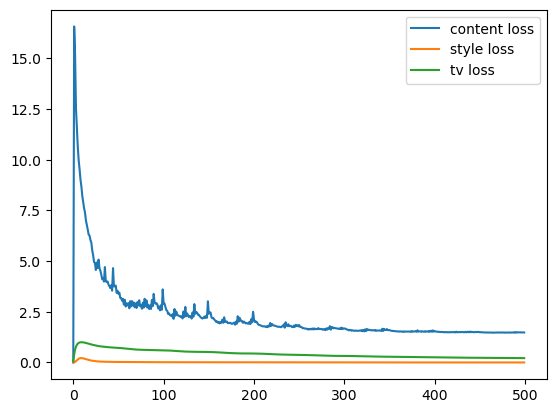

In [38]:
plt.plot(a, label='content loss')
plt.plot(b, label='style loss')
plt.plot(c, label='tv loss')
plt.legend()
plt.show()

image_test = post_process(x.cpu())
image_test.show()

In [41]:
# it will take 20 hrs, so the MPS has 10 times faster than cpu
image_shape = [300, 450]
content_weight, style_weight, tv_weight = 10, 1e3, 1
lr = 0.5
n_epoch = 500
lr_decay = 50
device = 'cpu'
net = net.to(device)
x, a, b, c = train(content_image, style_image, image_shape, lr, n_epoch, lr_decay, device,
                   content_weight, style_weight, tv_weight)

plt.plot(a, label='content loss')
plt.plot(b, label='style loss')
plt.plot(c, label='tv loss')
plt.legend()
plt.show()

image_test = post_process(x.cpu())
image_test.show()

cpu


 55%|█████▌    | 277/500 [12:12<09:49,  2.64s/it]


KeyboardInterrupt: 